# Neuromimetic (ECoG) stimulation

In [3]:
import numpy as np
from scipy.signal import hilbert

# Function to generate base ECoG-like signals within the specified range
def generate_ecog_like_base_signals(length, num_signals=8):
    signals = np.random.uniform(min_volt, max_volt, (num_signals, length))
    return signals

# Function to scale signals to a specific bit depth
def scale_signals_to_bit_depth(modified_signals, bit_depth):
    # Calculate the min and max values within the desired range
    min_val, max_val = min_volt, max_volt

    max_signal = np.max(modified_signals)
    min_signal = np.min(modified_signals)

    # Scale the signals to the specified bit depth while preserving the range
    scaled_signals = ((modified_signals - min_signal) / (max_signal - min_signal)) * (max_val - min_val) + min_val

    return modified_signals

# Function to apply amplitude variability while keeping the signals within the specified range
def apply_amplitude_variability(modified_signals, variability_factor=1.0):
    # Calculate the scaling factor to keep the signals within the range
    current_std = np.std(modified_signals)
    scaling_factor = np.sqrt(variability_factor) / current_std

    # Generate scaled noise
    scaled_noise = np.random.normal(0, scaling_factor, modified_signals.shape)

    # Add the scaled noise to the signals
    modified_signals += scaled_noise

    # Ensure that the modified signals do not exceed the specified range
    modified_signals = np.minimum(np.maximum(modified_signals, min_volt), max_volt)

    return modified_signals

# Function to apply variance while keeping the signals within the specified range
def apply_variance(modified_signals, variance=1.0):
    noise = np.random.normal(0, np.sqrt(variance), modified_signals.shape)
    modified_signals += noise
    
    # Ensure that the modified signals do not exceed the specified range
    modified_signals = np.minimum(np.maximum(modified_signals, min_volt), max_volt)
    
    return modified_signals

# Function to apply signal with standard deviation while keeping the signals within the specified range
def apply_signal_with_std(modified_signals, std_dev=1.0):
    # Calculate the scaling factor to keep the signals within the range
    current_std = np.std(modified_signals)
    scaling_factor = std_dev / current_std
    
    # Apply the scaled noise
    modified_signals += np.random.normal(0, scaling_factor * std_dev, modified_signals.shape)
    
    # Ensure that the modified signals do not exceed the specified range
    modified_signals = np.minimum(np.maximum(modified_signals, min_volt), max_volt)
    
    return modified_signals


# Function to apply signal with RMS value
def apply_signal_with_rms(modified_signals, rms_value=1.0):
    current_rms = np.sqrt(np.mean(modified_signals**2, axis=1, keepdims=True))
    scaling_factor = np.minimum(1.0, rms_value / current_rms)
    modified_signals *= scaling_factor
    return modified_signals


# Function to apply fractal structure
def apply_fractal_structure(modified_signals, fractal_dimension=0.8):
    length = modified_signals.shape[1]
    t = np.arange(length)
    fBm_signal = np.zeros((modified_signals.shape[0], length))
    
    for i in range(1, length):
        delta_t = t[i] - t[i - 1]
        fBm_signal[:, i] = fractal_dimension * fBm_signal[:, i - 1] + np.random.randn(modified_signals.shape[0]) * np.sqrt(delta_t)
    
    scaling_factor = np.maximum(min_volt / np.min(modified_signals), max_volt / np.max(modified_signals))
    modified_signals = modified_signals * scaling_factor
    
    return modified_signals
    
# Function to add peaks
def add_peaks(modified_signals, num_peaks=5, peak_height=1.0):
    if len(modified_signals) == 0:
        raise ValueError("Input modified_signals array must not be empty")
    num_signals, signal_length = modified_signals.shape
    scaling_factor = np.maximum(min_volt / np.min(modified_signals), max_volt / np.max(modified_signals))
    
    for i in range(num_signals):
        for _ in range(num_peaks):
            peak_position = np.random.randint(0, signal_length)
            modified_signals[i, peak_position] += peak_height * scaling_factor
            # Ensure that the modified signal does not exceed the specified range
            modified_signals[i, peak_position] = np.clip(modified_signals[i, peak_position], min_volt, max_volt)
            
    return modified_signals


# Function to apply moving average
def apply_moving_average(modified_signals, window_size=10):
    for i in range(len(modified_signals)):
        length = len(modified_signals[i])
        if length >= window_size:
            cumsum_vec = np.cumsum(np.insert(modified_signals[i], 0, 0))
            moving_average = (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size
            modified_signals[i, :length-window_size+1] = moving_average
            modified_signals[i, length-window_size+1:] = modified_signals[i, -window_size+1:]
    return modified_signals

# Function to apply zero-crossing rate
def apply_zero_crossing_rate(modified_signals, target_rate=0.1):
    def calculate_zero_crossing_rate(sig):
        zero_crossings = np.where(np.diff(np.sign(sig)))[0]
        return len(zero_crossings) / len(sig)

    for i in range(len(modified_signals)):
        current_rate = calculate_zero_crossing_rate(modified_signals[i])
        factor = target_rate / current_rate if current_rate > 0 else 1.0
        modified_signals[i] *= factor
    return modified_signals

# Function to apply Arnold tongues
def apply_arnold_tongues(modified_signals):
    num_signals, signal_length = modified_signals.shape
    
    for i in range(num_signals):
        # Generate a random K within the specified range
        K_range = (min_volt / (np.sin(np.pi / signal_length)), max_volt / (np.sin(np.pi / signal_length)))
        K = np.random.uniform(K_range[0], K_range[1])
        
        # Generate an Arnold tongue pattern
        omega = np.random.uniform(0.1, 2.0)  # Adjust the frequency range as needed
        t = np.linspace(0, 2 * np.pi * omega, signal_length)
        arnold_tongue_pattern = np.sin(t) * K
        
        # Add the Arnold tongue pattern to the signal
        modified_signals[i, :] += arnold_tongue_pattern

        # Ensure that the modified signal stays within the specified voltage range
        modified_signals[i, :] = np.minimum(np.maximum(modified_signals[i, :], min_volt), max_volt)

    return modified_signals

def apply_phase_synchronization(modified_signals, synchronization_level=0.5):
    length = len(modified_signals[0])
    common_phase = np.linspace(0, 2 * np.pi * synchronization_level, length)
    
    # Add the common phase to the signals
    for i in range(len(modified_signals)):
        modified_signals[i] += common_phase
    
    # Normalize the signals to stay within the specified voltage range
    min_signal = np.min(modified_signals)
    max_signal = np.max(modified_signals)
    
    if min_signal < min_volt or max_signal > max_volt:
        signal_range = max_signal - min_signal
        scaling_factor = (max_volt - min_volt) / signal_range
        modified_signals = (modified_signals - min_signal) * scaling_factor + min_volt
    
    return modified_signals

def apply_transfer_entropy(modified_signals, influence_factor, max_influence=5.0):
    num_signals = len(modified_signals)
    max_length = max(len(signal) for signal in modified_signals)
    
    # Normalize interaction weights to sum up to the influence factor
    interaction_weights = np.random.uniform(0, 1, (num_signals, num_signals))
    interaction_weights /= interaction_weights.sum(axis=1, keepdims=True)
    interaction_weights *= influence_factor
    
    for i in range(1, max_length):
        # Calculate the influenced signals
        influenced_signals = np.dot(interaction_weights, [signal[i - 1] if i < len(signal) else signal[-1] for signal in modified_signals])
        
        # Calculate the maximum possible influence to stay within the specified voltage range
        max_possible_influence = (max_volt - min_volt) / max_length
        
        # Scale down the influenced signals if necessary
        if np.max(np.abs(influenced_signals)) > max_possible_influence:
            scaling_factor = max_possible_influence / np.max(np.abs(influenced_signals))
            influenced_signals *= scaling_factor
        
        # Add the influenced signals to the original signals
        for j in range(num_signals):
            if i < len(modified_signals[j]):
                modified_signals[j][i] += influenced_signals[j]

    return modified_signals

# Function to apply Hilbert-Huang transform
def apply_hilbert_huang(modified_signals):
    for i in range(len(modified_signals)):
        signal = modified_signals[i]
        
        # Calculate the amplitude for the low-frequency component (lowest 10%)
        low_freq_amplitude = 0.05 * (max_volt - min_volt)
        low_freq_signal = low_freq_amplitude * np.sin(2 * np.pi * 0.1 * np.arange(len(signal)))
        
        # Calculate the amplitude for the high-frequency component (highest 10%)
        high_freq_amplitude = 0.05 * (max_volt - min_volt)
        high_freq_noise = high_freq_amplitude * np.random.randn(len(signal))
        
        # Combine the components
        modulated_signal = signal + low_freq_signal + high_freq_noise

        # Clip the signal to the specified range
        modulated_signal = np.clip(modulated_signal, min_volt, max_volt)

        modified_signals[i] = modulated_signal

    return modified_signals

# Function to apply spectral centroids
def apply_spectral_centroids(modified_signals, centroid_factor=0.8, edge_density_factor=0.8):
    for i in range(modified_signals.shape[0]):
        fft_spectrum = np.fft.fft(modified_signals[i])
        freq = np.fft.fftfreq(len(modified_signals[i]))
        centroid = np.sum(freq * np.abs(fft_spectrum)) / np.sum(np.abs(fft_spectrum))
        edge_density = np.sum(np.abs(np.diff(fft_spectrum))) / np.sum(np.abs(fft_spectrum))
        adjusted_spectrum = fft_spectrum * (centroid_factor * centroid + edge_density_factor * edge_density)
        modified_signals[i] = np.fft.ifft(adjusted_spectrum).real
    return modified_signals
    
# Function to apply dynamic time warping
def apply_dynamic_time_warping(modified_signals, reference_signal, warping_factor, min_volt, max_volt):
    modified_signals_aligned = []

    reference_signal = np.array(reference_signal)  # Convert the reference signal to a numpy array

    for signal in modified_signals:
        signal = np.array(signal)  # Convert the signal to a numpy array

        # Perform dynamic time warping
        signal_length = len(signal)
        time_vector = np.linspace(0, 1, signal_length)
        reference_time_vector = np.linspace(0, 1, len(reference_signal)) * warping_factor
        modified_signal = np.interp(time_vector, reference_time_vector, reference_signal)

        # Normalize the signal to stay within the desired range
        current_min = np.min(modified_signal)
        current_max = np.max(modified_signal)

        # Calculate the scaling factor to keep the signal within the specified range
        scaling_factor = (max_volt - min_volt) / (current_max - current_min)

        # Apply the scaling factor while preserving the signal's shape
        modified_signal = (modified_signal - current_min) * scaling_factor + min_volt

        modified_signals_aligned.append(modified_signal)

    return np.array(modified_signals)
    
def apply_fft(modified_signals, complexity_factor):
    modified_signals_complexity = []

    for signal in modified_signals:
        # Apply FFT to each signal
        spectrum = np.fft.fft(signal)
        freq = np.fft.fftfreq(len(signal))

        # Calculate the scaling factor to keep the signal within the range
        current_max = np.max(signal)
        current_min = np.min(signal)
        scaling_factor = max_volt / (current_max - current_min)

        # Apply complexity modification
        modified_spectrum = spectrum * (1 + np.random.randn(len(spectrum)) * complexity_factor)
        
        # Transform back to time domain
        modified_signal = np.fft.ifft(modified_spectrum).real
        
        # Scale the signal while preserving the range
        modified_signal = (modified_signal - current_min) * scaling_factor + min_volt
        modified_signals_complexity.append(modified_signal)

    return np.array(modified_signals)

def apply_signal_evolution(modified_signals, evolution_rate=0.8):
    modified_signals_evolution = np.zeros_like(modified_signals)
    for i in range(modified_signals.shape[0]):
        modified_signals_evolution[i, 0] = np.random.randn()
        for t in range(1, modified_signals.shape[1]):
            modified_signals_evolution[i, t] = modified_signals_evolution[i, t - 1] + evolution_rate * np.random.randn()
    return modified_signals

def apply_phase_amplitude_coupling(modified_signals, low_freq=8.0, high_freq=40.0):
    modified_signals_pac = np.zeros_like(modified_signals)
    time = np.linspace(0, 1, modified_signals.shape[1])
    for i in range(modified_signals.shape[0]):
        low_freq_signal = np.sin(2 * np.pi * low_freq * time)
        high_freq_signal = np.sin(2 * np.pi * high_freq * time)
        modified_signals_pac[i] = (1 + low_freq_signal) * high_freq_signal
    return modified_signals

def apply_granger_causality(modified_signals, causality_strength=0.8):
    modified_signals_granger = np.copy(modified_signals)
    num_signals, signal_length = modified_signals.shape
    for i in range(1, num_signals):
        for j in range(num_signals):
            if i != j:
                causal_effect = modified_signals[j, :-i] * causality_strength
                modified_signals_granger[i, i:] += causal_effect
    return modified_signals

def apply_multivariate_empirical_mode_decomposition(modified_signals, num_imfs=4):
    num_channels, signal_length = modified_signals.shape
    memd_signals = np.zeros((num_channels, num_imfs, signal_length))
    for channel in range(num_channels):
        for imf_idx in range(num_imfs):
            imf = np.sin(2 * np.pi * (imf_idx + 1) * np.linspace(0, 1, signal_length))
            amplitude_scaling = np.random.uniform(0.5, 2.0)
            memd_signals[channel, imf_idx, :] = amplitude_scaling * imf
    modified_signals_memd = modified_signals + np.sum(memd_signals, axis=1)
    return modified_signals

def apply_normalized_states(modified_signals):
    def generate_random_hermitian_matrix(signal_length): 
        size = signal_length
        A = np.random.rand(size, size) + 1j * np.random.rand(size, size)
        return A + A.conj().T

    def construct_density_matrix(signal_length, modified_signals):
        reconstructed_density_matrices = []

        for signal in modified_signals:
            hermitian_matrix = generate_random_hermitian_matrix(signal_length)
            eigenvalues, eigenvectors = np.linalg.eigh(hermitian_matrix)
            density_matrix = np.dot(eigenvectors, np.dot(np.diag(eigenvalues), eigenvectors.T.conj()))
            reconstructed_density_matrices.append(density_matrix)
        return reconstructed_density_matrices

    def generate_coherence(density_matrices):
        coherence_values = []

        for density_matrix in density_matrices:
            eigenvalues = np.linalg.eigvalsh(density_matrix)
            sorted_eigenvalues = np.sort(np.abs(eigenvalues))
            coherence = np.sum(sorted_eigenvalues) - np.sum(sorted_eigenvalues[-2:])
            coherence_values.append(coherence)
        return coherence_values

    signal_length = modified_signals[0].shape[0]
    density_matrices = construct_density_matrix(signal_length, modified_signals)
    coherence_values = generate_coherence(density_matrices)

    modified_signals_normalized = []

    for density_matrix in density_matrices:
        reconstructed_signal = np.diag(density_matrix).real
        modified_signals_normalized.append(reconstructed_signal)

    return modified_signals_normalized, density_matrices, coherence_values

# Define the list of transformation functions
transformations = [
    lambda x: scale_signals_to_bit_depth(x, bit_depth),
    lambda x: apply_amplitude_variability(x, variability_factor=0.05),
    lambda x: apply_variance(x, variance=0.5),
    lambda x: apply_signal_with_std(x, std_dev=0.5),
    lambda x: apply_signal_with_rms(x, rms_value=0.5),
    lambda x: apply_fractal_structure(x, fractal_dimension=0.8),  
    lambda x: add_peaks(x, num_peaks=5, peak_height=1.0),
    lambda x: apply_moving_average(x, window_size=10),
    lambda x: apply_zero_crossing_rate(x, target_rate=0.1),
    lambda x: apply_arnold_tongues(x),
    lambda x: apply_phase_synchronization(x, synchronization_level=0.5),
    lambda x: apply_transfer_entropy(x, influence_factor=1.0),
    lambda x: apply_hilbert_huang(x),
    lambda x: apply_dynamic_time_warping(x, reference_signal=np.mean(x, axis=0), warping_factor=0.5, min_volt=min_volt, max_volt=max_volt),
    lambda x: apply_fft(x, complexity_factor=0.5),
    lambda x: apply_spectral_centroids(x, centroid_factor=0.8, edge_density_factor=0.8),
    lambda x: apply_signal_evolution(x, evolution_rate=0.8),
    lambda x: apply_phase_amplitude_coupling(x, low_freq=8.0, high_freq=40.0),
    lambda x: apply_granger_causality(x, causality_strength=0.8),
    lambda x: apply_multivariate_empirical_mode_decomposition(x, num_imfs=4),
]

# Main function to generate and transform signals
def generate_transformed_signals(signal_length, num_signals, transformation_functions):
    modified_signals = generate_ecog_like_base_signals(signal_length, num_signals)

    for transform in transformation_functions:
        modified_signals = transform(modified_signals)
        # Convert list to NumPy array if necessary
        if isinstance(modified_signals, list):
            modified_signals = np.array(modified_signals)

        if np.isnan(modified_signals).any() or np.isinf(modified_signals).any():
            print(f"NaNs or Infinities found after {transform.__name__}")
        print(f"Range after {transform.__name__}: {modified_signals.min()} to {modified_signals.max()}")

    # Normalize and scale to full 16-bit range
    modified_signals = scale_signals_to_bit_depth(modified_signals, 16)
    print(f"Scaled range: {modified_signals.min()} to {modified_signals.max()}")

    return modified_signals

# Main execution
if __name__ == "__main__":
    bit_depth = 16        # Bit depth of the signals
    num_signals = 8      # Number of signals
    sampling_rate = 50   # Sampling rate in Hz
    duration = 1        # Duration in seconds
    length = sampling_rate * duration

    # Global variables for amplitude range
    min_volt = 1e-6  # 1 microvolt
    max_volt = 8e-6  # 8 microvolts

    # Calculate the length of the signals
    length = sampling_rate * duration

    # Generate and transform the ECoG-like signals
    transformed_signals = generate_transformed_signals(length, num_signals, transformations)

    # Handle 'apply_normalized_states' separately
    modified_signals, density_matrices, coherence_values = apply_normalized_states(transformed_signals)

    # Convert modified_signals to a NumPy array to access the shape attribute
    modified_signals_array = np.array(modified_signals)

    # Check the shape and a sample of the generated signals
    print(f"Shape of generated ECoG-like signals: {modified_signals_array.shape}")
    print(f"Sample of first signal: {modified_signals_array[0][:100]}")

Range after <lambda>: 1.0137065979431356e-06 to 7.983594226340235e-06
Range after <lambda>: 1e-06 to 8e-06
Range after <lambda>: 1e-06 to 8e-06
Range after <lambda>: 1e-06 to 8e-06
Range after <lambda>: 1e-06 to 8e-06
Range after <lambda>: 1e-06 to 8e-06
Range after <lambda>: 1e-06 to 8e-06
Range after <lambda>: 1e-06 to 8.000000000000001e-06
Range after <lambda>: 1e-06 to 8.000000000000001e-06
Range after <lambda>: 1e-06 to 8e-06
Range after <lambda>: 1e-06 to 8e-06
Range after <lambda>: 1e-06 to 8.14e-06
Range after <lambda>: 1e-06 to 8e-06
Range after <lambda>: 1e-06 to 8e-06
Range after <lambda>: 1e-06 to 8e-06
Range after <lambda>: 5.319961431818888e-07 to 4.694015429972029e-06
Range after <lambda>: 5.319961431818888e-07 to 4.694015429972029e-06
Range after <lambda>: 5.319961431818888e-07 to 4.694015429972029e-06
Range after <lambda>: 5.319961431818888e-07 to 4.694015429972029e-06
Range after <lambda>: 5.319961431818888e-07 to 4.694015429972029e-06
Scaled range: 5.319961431818888e

# Visualise

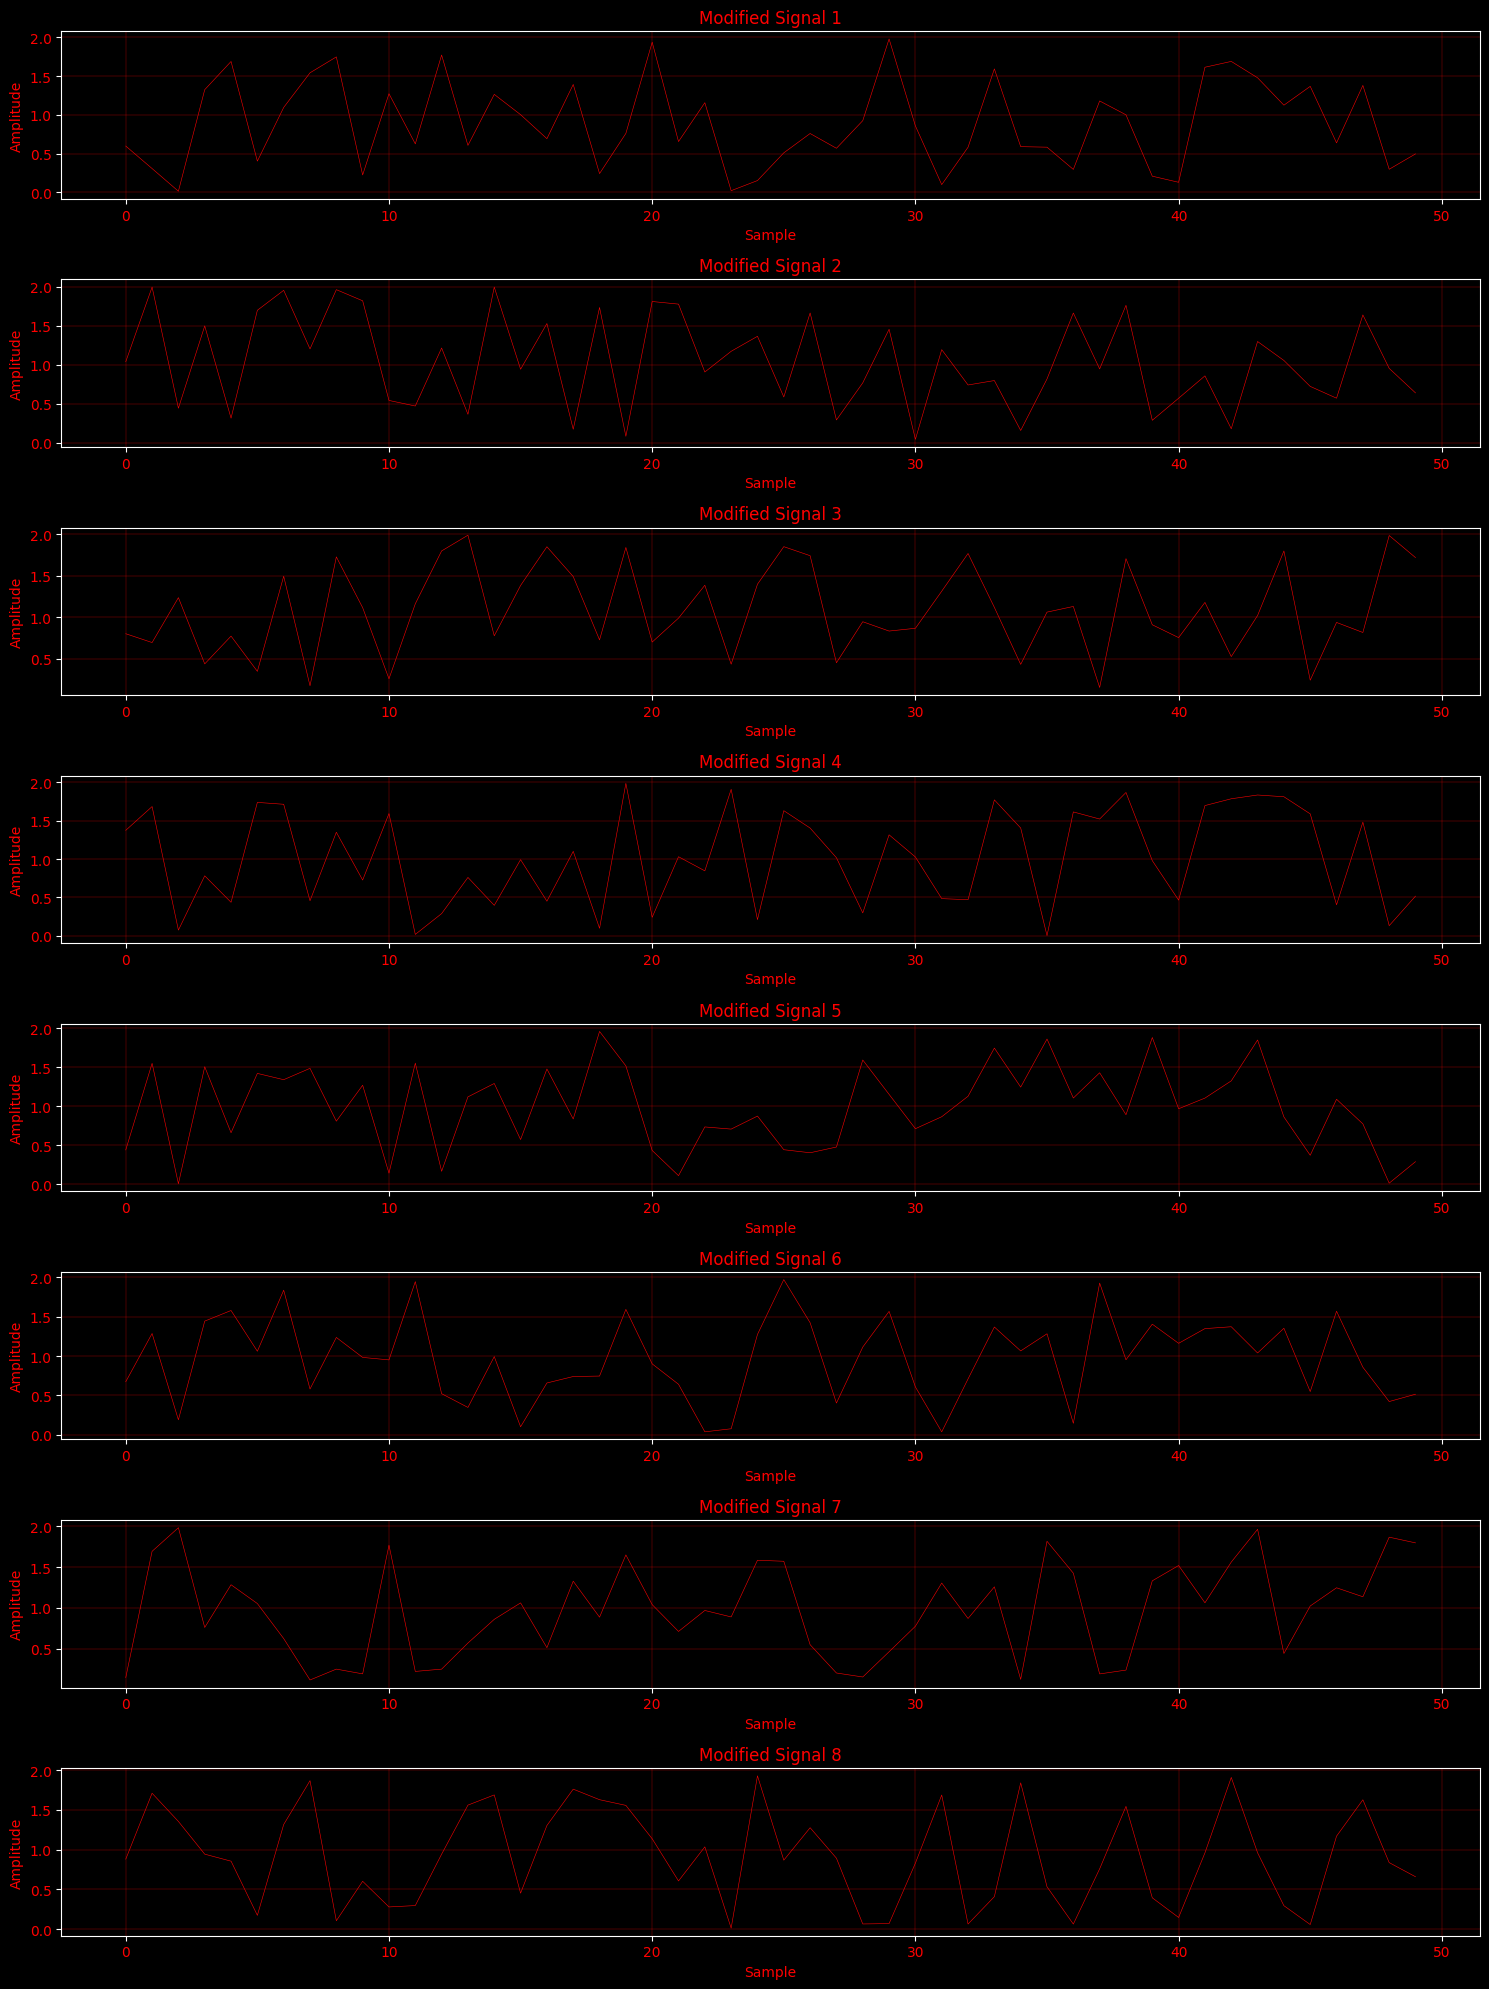

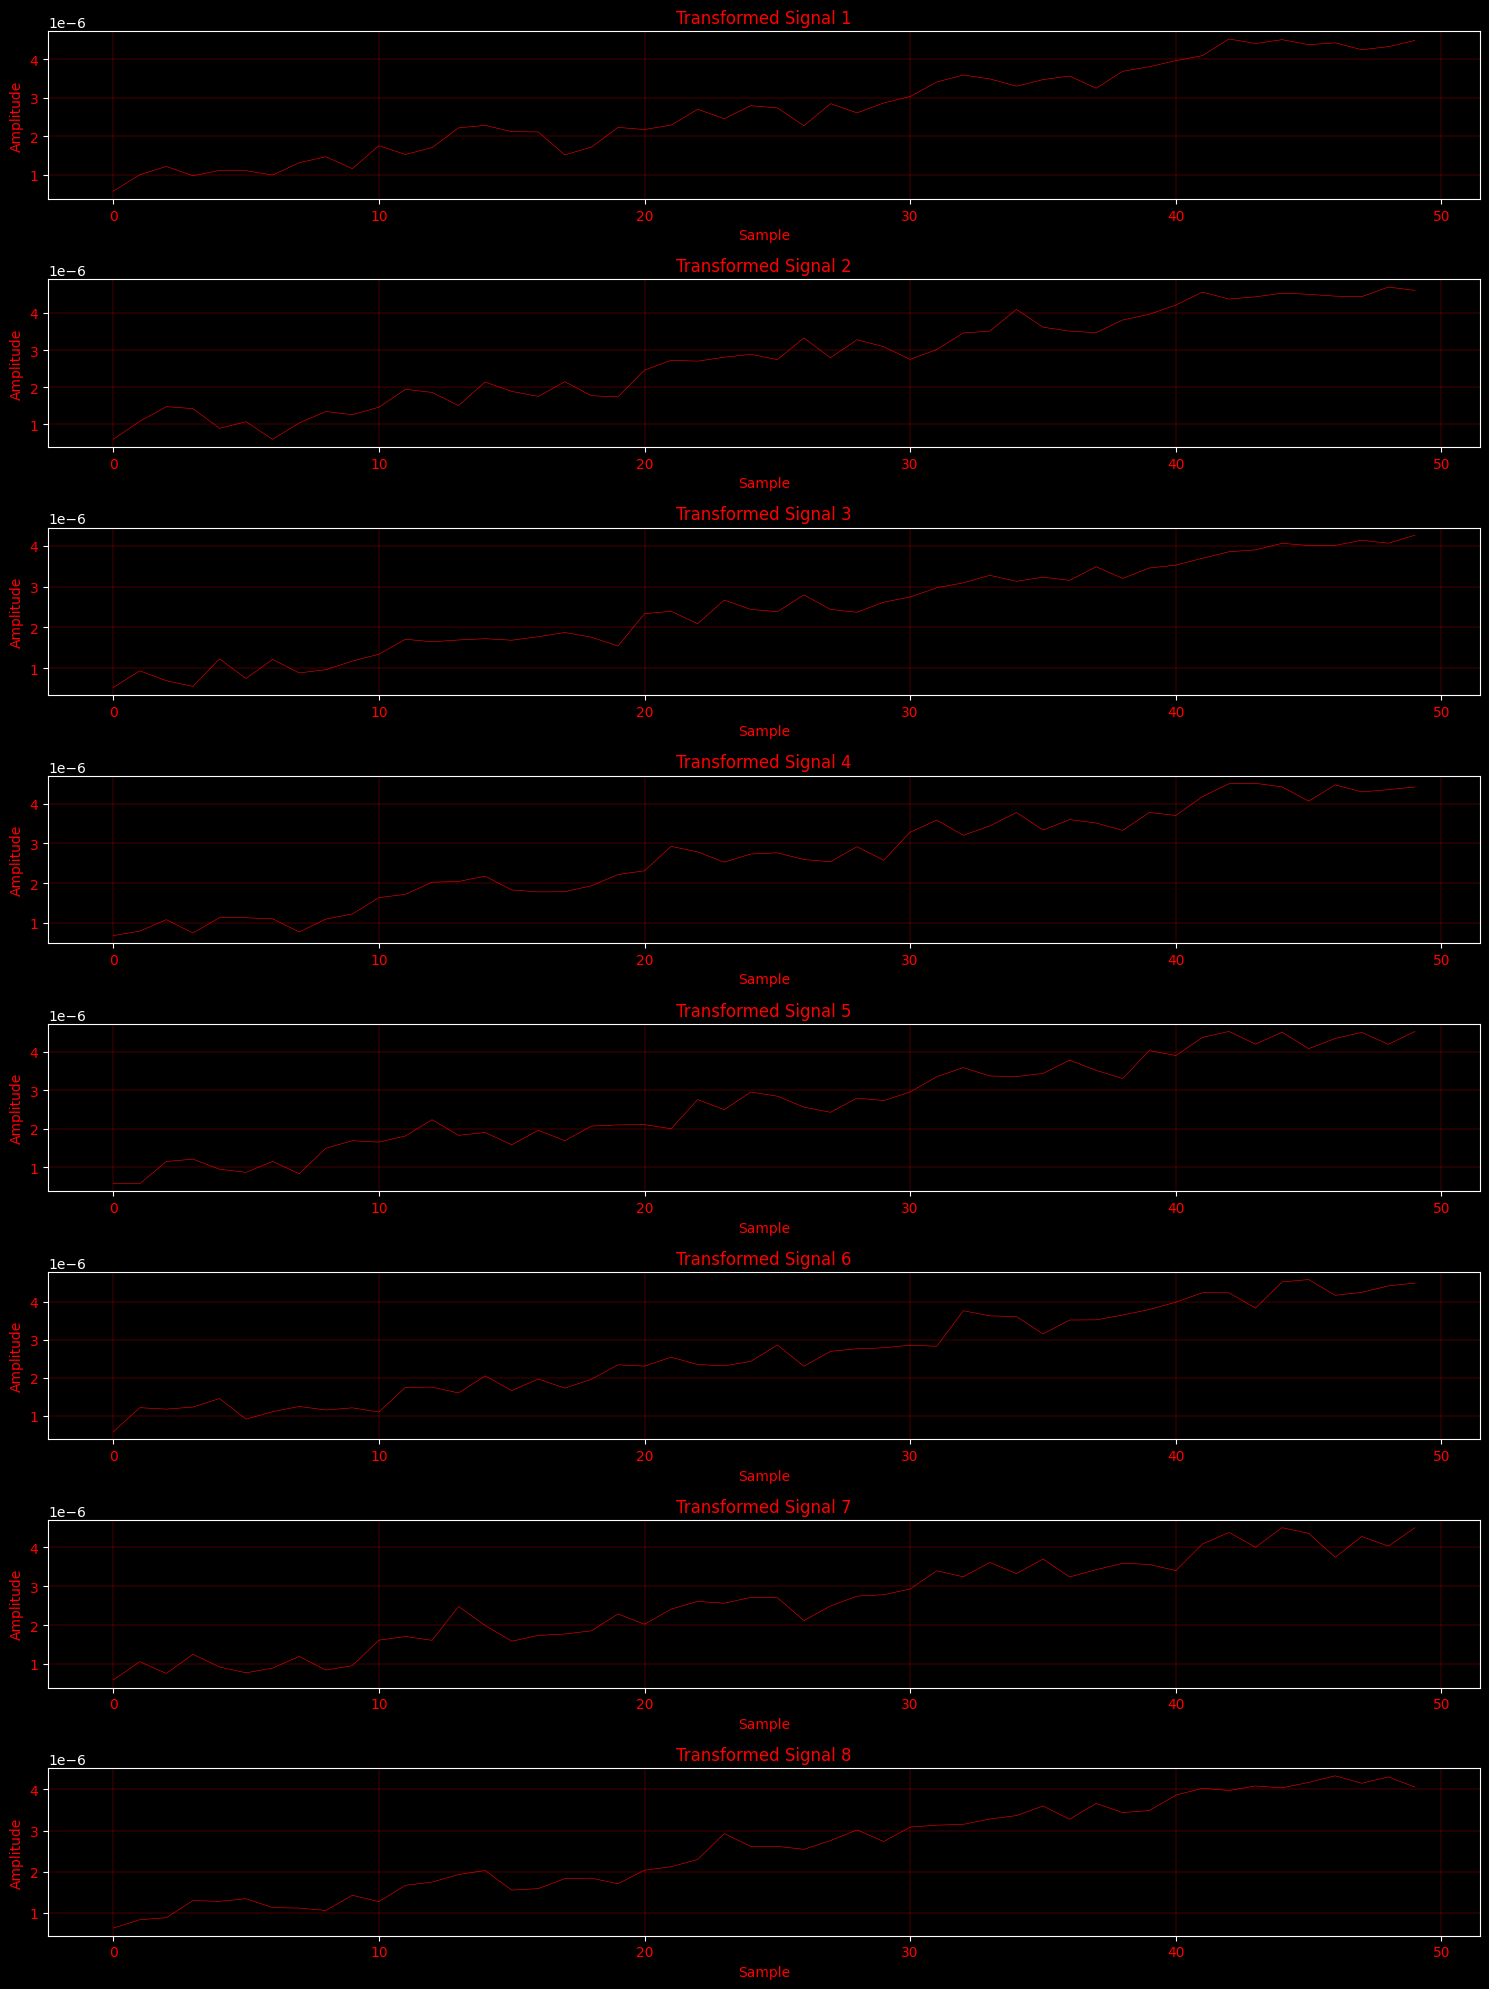

In [4]:
import matplotlib.pyplot as plt

def plot_separate_signals(signals, title_prefix):
    """
    Plot each signal in a separate subplot.

    Parameters:
    signals (numpy.ndarray): Array of signal arrays to plot.
    title_prefix (str): Prefix for the title of each plot.
    """
    num_signals = signals.shape[0]
    plt.figure(figsize=(15, 20))
    plt.style.use('dark_background')

    for i in range(num_signals):
        plt.subplot(num_signals, 1, i+1)
        plt.plot(signals[i], color='red', linewidth=0.4)  # Adjust the linewidth here
        plt.title(f'{title_prefix} Signal {i+1}', color='red')
        plt.xlabel('Sample', color='red')
        plt.ylabel('Amplitude', color='red')
        plt.xticks(color='red')
        plt.yticks(color='red')
        plt.grid(True, which='both', color='red', linestyle='-', linewidth=0.2)

    plt.tight_layout()
    plt.show()

# Plot the modified and transformed signals
plot_separate_signals(modified_signals_array, 'Modified')
plot_separate_signals(transformed_signals, 'Transformed')
